# Linear Models

In [286]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [316]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_fires = pd.read_sql_query("""
select
	weather_county.fips,
	weather_county.month,
	weather_county.date,
	weather_county.year,
	weather_county.precipitation,
	weather_county.pressure,
	weather_county.humidity_2m,
	weather_county.temp_2m,
	weather_county.temp_dew_point_2m,
	weather_county.temp_wet_bulb_2m,
	weather_county.temp_max_2m,
	weather_county.temp_min_2m,
	weather_county.temp_range_2m,
	weather_county.temp_0m,
	weather_county.wind_10m,
	weather_county.wind_max_10m,
	weather_county.wind_min_10m,
	weather_county.wind_range_10m,
	weather_county.wind_50m,
	weather_county.wind_max_50m,
	weather_county.wind_min_50m,
	weather_county.wind_range_50m,
	weather_county.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,

	ifnull(fires.fire_size, 0) as fire_size,
  ifnull(fires.fire_size_class, '') as fire_size_class
from weather_county
inner join soil
left outer join (
	select max(fire_size) as fire_size, max(fire_size_class) as fire_size_class, fips, date
	from fires
	where
		cause_descr in (
			'Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire'
		)
	group by fips, date
) as fires on
  fires.fips = weather_county.fips
  and fires.date = weather_county.date
where
  soil.fips = weather_county.fips
	and weather_county.month in (8, 9, 10, 11)
""", conn)

# TODO: try joining on a week date range in case the fire discovery date was late

print(df_fires.columns)

conn.close()

Index(['fips', 'month', 'date', 'year', 'precipitation', 'pressure',
       'humidity_2m', 'temp_2m', 'temp_dew_point_2m', 'temp_wet_bulb_2m',
       'temp_max_2m', 'temp_min_2m', 'temp_range_2m', 'temp_0m', 'wind_10m',
       'wind_max_10m', 'wind_min_10m', 'wind_range_10m', 'wind_50m',
       'wind_max_50m', 'wind_min_50m', 'wind_range_50m', 'drought_score',
       'elevation', 'slope_005', 'slope_005_02', 'slope_02_05', 'slope_05_10',
       'slope_10_15', 'slope_15_30', 'slope_30_45', 'slope_45', 'aspect_north',
       'aspect_east', 'aspect_south', 'aspect_west', 'aspect_unknown',
       'water_land', 'barren_land', 'urban_land', 'grass_land', 'forest_land',
       'partial_cultivated_land', 'irrigated_land', 'cultivated_land',
       'nutrient', 'nutrient_retention', 'rooting', 'oxygen', 'excess_salts',
       'toxicity', 'workablity', 'fire_size', 'fire_size_class'],
      dtype='object')


In [317]:
from datetime import datetime

df_fires.date = pd.to_datetime(df_fires.date)
df_fires['day_of_week'] = df_fires.date.dt.dayofweek

print(df_fires.info())

X_trim = df_fires.drop(['date', 'fire_size', 'fire_size_class',
  # 'humidity_2m',
  # 'temp_2m', 'temp_dew_point_2m', 'temp_wet_bulb_2m', 'temp_max_2m', 'temp_min_2m', 'temp_range_2m', 'temp_0m',
  # 'elevation',
  # 'slope_005','slope_005_02', 'slope_02_05', 'slope_05_10', 'slope_10_15', 'slope_15_30', 'slope_30_45', 'slope_45',
  # 'aspect_north', 'aspect_east', 'aspect_south', 'aspect_west', 'aspect_unknown',
  # 'water_land', 'barren_land', 'urban_land', 'grass_land', 'forest_land', 'partial_cultivated_land', 'irrigated_land', 'cultivated_land',
  # 'nutrient', 'nutrient_retention', 'rooting', 'oxygen', 'excess_salts', 'toxicity', 'workablity'
  ],
  axis=1)

X_encoded = pd.get_dummies(X_trim, columns=['fips', 'day_of_week', 'year', 'month'])
print(X_encoded.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113216 entries, 0 to 113215
Data columns (total 55 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fips                     113216 non-null  int64         
 1   month                    113216 non-null  int64         
 2   date                     113216 non-null  datetime64[ns]
 3   year                     113216 non-null  int64         
 4   precipitation            113216 non-null  float64       
 5   pressure                 113216 non-null  float64       
 6   humidity_2m              113216 non-null  float64       
 7   temp_2m                  113216 non-null  float64       
 8   temp_dew_point_2m        113216 non-null  float64       
 9   temp_wet_bulb_2m         113216 non-null  float64       
 10  temp_max_2m              113216 non-null  float64       
 11  temp_min_2m              113216 non-null  float64       
 12  temp_range_2m   

In [318]:
scaler = StandardScaler()
scaler.fit(X_encoded)
X = scaler.transform(X_encoded)

y = (df_fires.fire_size_class > 'A').values # Ignore small fires ('' or 'A') for now

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

params={
  'C': [0.1, 1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='accuracy', cv=5)

log_reg.fit(X, y)

print(f'Estimator', log_reg.best_estimator_)

Estimator LogisticRegression(C=1, max_iter=1000, solver='liblinear')


In [319]:
num_fires = (y == 1).sum()
num_data_pt = len(y)
print(f'{num_fires} non-small fires out of {len(y)} data points')
print(f'No fires {1 - round(num_fires/num_data_pt, 2)}% of the time')

print('--------- Log Regression Accuracy ---------')
print(accuracy_score(log_reg.predict(X_test), y_test))

y_pred_log_reg = log_reg.predict(X_train)

print('--------- Log Regression Classification ---------')
print(classification_report(y_train, y_pred_log_reg))

9291 non-small fires out of 113216 data points
No fires 0.92% of the time
--------- Log Regression Accuracy ---------
0.9202586206896551
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     77911
        True       0.58      0.03      0.06      7001

    accuracy                           0.92     84912
   macro avg       0.75      0.52      0.51     84912
weighted avg       0.89      0.92      0.88     84912



In [320]:
from sklearn.ensemble import RandomForestClassifier

params = {
  'n_estimators': np.arange(40, 120, 20),
  # 'splitter': ['best', 'random'],
  'max_features': np.arange(2, 15, 1),
  'max_depth': np.arange(10, 20, 1),
  'min_samples_split': np.arange(2, 10, 1),
  'min_samples_leaf': np.arange(1, 10, 1),
  'max_leaf_nodes': np.arange(5, 15, 1),
}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), params)
rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)
print(f'Best Score', rand_forest.best_score_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': 3, 'max_depth': 16}
Best Score 0.9175499343968381
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     26014
        True       0.00      0.00      0.00      2290

    accuracy                           0.92     28304
   macro avg       0.46      0.50      0.48     28304
weighted avg       0.84      0.92      0.88     28304



/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


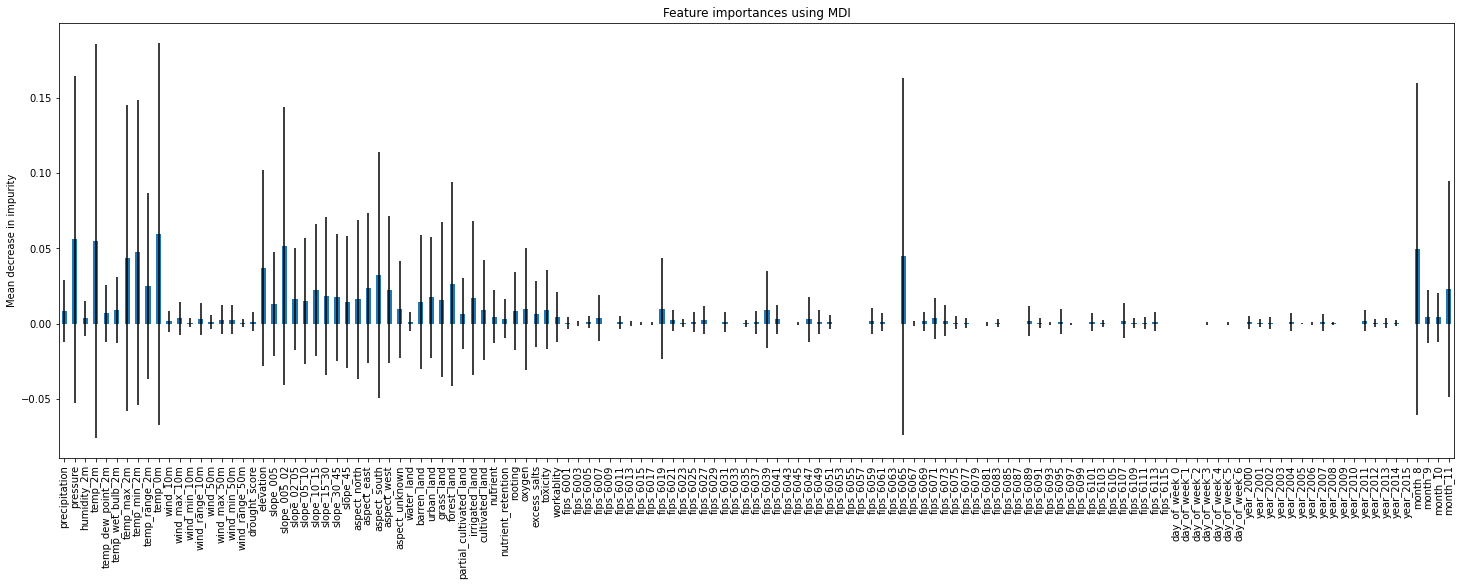

In [321]:
importances = rand_forest.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X_encoded.columns.values)
std = np.std([tree.feature_importances_ for tree in rand_forest.best_estimator_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.set_figheight(8)
fig.set_figwidth(25)

In [304]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [3, 4, 5],
  'gamma':[0.5, 1, 5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1],
  'n_estimators': [500, 600],
  'eval_metric': ['logloss']
}

xgb_clf = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params)

xgb_clf.fit(X_train, y_train)

print("Best Params:", xgb_clf.best_params_)

# Best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 0.9}

Best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 1.0}


In [305]:
y_pred_xgb = xgb_clf.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     26117
        True       0.65      0.03      0.06      2187

    accuracy                           0.92     28304
   macro avg       0.79      0.52      0.51     28304
weighted avg       0.90      0.92      0.89     28304

